In [264]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm, skew 
from scipy.special import boxcox1p
#inv - inv_boxcox1p(y, 2.5)
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge

In [265]:
df = pd.read_csv('../housing.data', sep='\s+', header=None, names=['CRIM', 'ZN', 'INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])

In [266]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [267]:
df['MEDV'] = np.log1p(df['MEDV'])

In [268]:
df['MEDV'].describe()

count    506.000000
mean       3.085437
std        0.386966
min        1.791759
25%        2.891757
50%        3.100092
75%        3.258097
max        3.931826
Name: MEDV, dtype: float64

In [269]:
for i in df.columns[:-1]:
    print(i)
    print(df[i].skew(), df[i].kurt())
    if i != 'CHAS' and (abs(df[i].skew()) > 0.75):
        df[i] = boxcox1p(df[i], 0.35)
        #df[i] = np.log1p(df[i])

        print(df[i].skew(), df[i].kurt())
    
    print('--------------------------')

CRIM
5.223148798243851 37.13050912952203
1.9740843132332258 4.308580743930477
--------------------------
ZN
2.2256663227354307 4.031510083739155
1.4314701905207694 0.537160832923989
--------------------------
INDUS
0.29502156787351164 -1.2335396011495188
--------------------------
CHAS
3.405904172058746 9.638263777819526
--------------------------
NOX
0.7293079225348787 -0.06466713336542629
--------------------------
RM
0.40361213328874385 1.8915003664993404
--------------------------
AGE
-0.5989626398812962 -0.9677155941626912
--------------------------
DIS
1.0117805793009007 0.4879411222443908
0.5524972546768439 -0.6085593626946499
--------------------------
RAD
1.0048146482182057 -0.8672319936034931
0.7928936001671438 -0.9257488088889918
--------------------------
TAX
0.669955941795016 -1.1424079924768082
--------------------------
PTRATIO
-0.8023249268537809 -0.28509138330538875
-0.9304346714775735 0.014518330337779162
--------------------------
B
-2.8903737121414492 7.226817549260

In [270]:
num_features = ['CRIM', 'ZN', 'INDUS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']

In [271]:
data_num = df[num_features]

In [272]:
data_catg = pd.get_dummies(df['CHAS'], prefix='CHAS')

In [273]:
y = df['MEDV']

In [274]:
data = pd.concat([data_num, data_catg], axis=1)

In [275]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.2, random_state = 101)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (404, 14)
X_test : (102, 14)
y_train : (404,)
y_test : (102,)


In [276]:
X_train.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS_0,CHAS_1
288,0.045232,8.64704,5.32,0.405,6.315,45.6,3.139718,2.788537,293.0,4.938670,20.362356,3.210310,1,0
72,0.089040,0.00000,10.81,0.413,6.065,7.8,2.580296,2.161329,305.0,5.323830,20.239411,2.649902,1,0
471,2.174788,0.00000,18.10,0.532,6.229,90.7,1.824307,5.957627,666.0,5.463359,20.330248,4.315162,1,0
176,0.068677,0.00000,4.05,0.510,6.020,47.2,2.000209,2.492009,296.0,4.938670,20.287173,3.779247,1,0
320,0.159229,0.00000,7.38,0.493,6.426,52.3,2.344869,2.492009,287.0,5.380169,20.362356,3.110005,1,0


In [277]:
#stdSc = StandardScaler()
#X_train.loc[:, num_features] = stdSc.fit_transform(X_train.loc[:, num_features])
#X_test.loc[:, num_features] = stdSc.transform(X_test.loc[:, num_features])

In [278]:
minmaxSc = MinMaxScaler()
X_train.loc[:, num_features] = minmaxSc.fit_transform(X_train.loc[:, num_features])
X_test.loc[:, num_features] = minmaxSc.transform(X_test.loc[:, num_features])

In [279]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test =y_test.values
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (404, 14)
X_test : (102, 14)
y_train : (404,)
y_test : (102,)


## Single Model Approaches

### linear regression

In [92]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [93]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

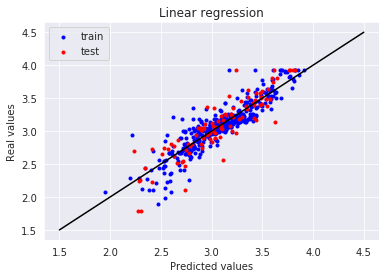

In [94]:
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = ".", label = "train")
plt.scatter(y_test_pred, y_test, c = "red", marker = ".", label = "test")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([1.5, 4.5], [1.5, 4.5], c = "black")
plt.show()

In [202]:
def rmse_5cv(model):
    kf = KFold(5, shuffle=True, random_state=101)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [167]:
lr = LinearRegression()
score = rmse_5cv(lr)

In [168]:
score.mean()

0.16783561350765622

In [203]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test_pred,y_test))
print(np.sqrt(mean_squared_error(y_test_pred,y_test)))

0.02249062414384502
0.14996874388966863


boxcox15 0.16760678508776772 - 0.20534528933159496
log 0.1702368806876507  - 0.2089983700614208
boxcox15 0.16849535250900521 - 0.20562120189863783
boxcox16 0.16748176282779798 - 0.2051604924188348
boxcox17 0.16736365979995055 - 0.20498382871788645
boxcox18 0.1672525634347004  - 0.20481541082894467
boxcox19 0.1671485545733451 - 0.20465534420971876
boxcox20 0.1670517071708548 - 0.20450372694349928
boxcox30 0.16666368397219505 - 0.20332633753742121
boxcox35 0.16648513932706382 - 0.20328585706300625

### ridge regression

In [102]:
ridge = RidgeCV(cv=5, alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 0.1
Try again for more precision with alphas centered around 0.1
Best alpha : 0.13999999999999999


In [103]:
ridge = Ridge(alpha=alpha)
score = rmse_5cv(ridge)

In [104]:
score.mean()

0.16754829119499162

In [105]:
ridge.fit(X_train, y_train)
y_test_pred = ridge.predict(X_test)
print(np.sqrt(mean_squared_error(y_test_pred,y_test)))

0.2040381543426511


### lasso regression

In [106]:


# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.0001
Try again for more precision with alphas centered around 0.0001
Best alpha : 6e-05


In [107]:
lasso = Lasso(alpha=alpha)
score = rmse_5cv(lasso)

In [108]:
score.mean()

0.16771286073615346

In [109]:
lasso.fit(X_train, y_train)
y_test_pred = lasso.predict(X_test)
print(np.sqrt(mean_squared_error(y_test_pred,y_test)))

0.20349418494262259


### ElasticNet

In [110]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.1
Best alpha : 0.0003
Try again for more precision with l1_ratio centered around 0.1
Best l1_ratio : 0.085
Best alpha : 0.0003
Now try again for more precision on alpha, with l1_ratio fixed at 0.085 and alpha centered around 0.0003
Best l1_ratio : 0.085
Best alpha : 0.000225


In [111]:
elanet = ElasticNet(alpha=alpha, l1_ratio=ratio)
score = rmse_5cv(elanet)

In [112]:
score.mean()

0.1676317077617701

In [113]:
elanet.fit(X_train, y_train)
y_test_pred = elanet.predict(X_test)
print(np.sqrt(mean_squared_error(y_test_pred,y_test)))

0.20379852070994522


### Kernel Ridge Regression

In [114]:
KRR = KernelRidge(alpha=0.13999, kernel='polynomial', degree=7, coef0=3.5)

In [115]:
score = rmse_5cv(KRR)
score.mean()

0.1465256941047225

In [116]:
KRR.fit(X_train, y_train)
y_test_pred = KRR.predict(X_test)
print(np.sqrt(mean_squared_error(y_test_pred,y_test)))

0.158006410865553


In [117]:
y_train_pred = KRR.predict(X_train)
y_test_pred = KRR.predict(X_test)

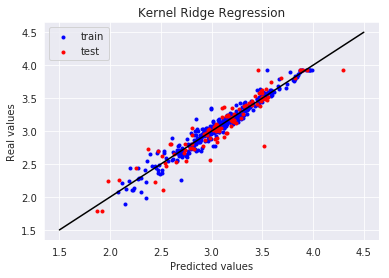

In [118]:
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = ".", label = "train")
plt.scatter(y_test_pred, y_test, c = "red", marker = ".", label = "test")
plt.title("Kernel Ridge Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([1.5, 4.5], [1.5, 4.5], c = "black")
plt.show()

In [119]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

In [120]:
import xgboost as xgb
import lightgbm as lgb

### Gradient Boosting Regression

In [121]:
gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [122]:
score = rmse_5cv(gboost)
score.mean()

0.1400735617041558

In [123]:
gboost.fit(X_train, y_train)
y_test_pred = gboost.predict(X_test)
print(np.sqrt(mean_squared_error(y_test_pred,y_test)))

0.15545334623980006


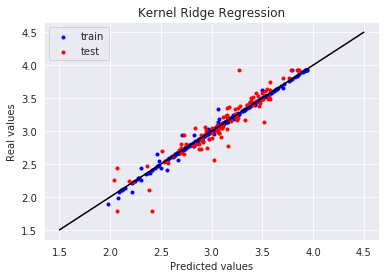

In [124]:
y_train_pred = gboost.predict(X_train)
y_test_pred = gboost.predict(X_test)
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = ".", label = "train")
plt.scatter(y_test_pred, y_test, c = "red", marker = ".", label = "test")
plt.title("Kernel Ridge Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([1.5, 4.5], [1.5, 4.5], c = "black")
plt.show()

### XGBoost

In [125]:
xgboost = xgb.XGBRegressor(colsample_bytree=0.38, gamma=0.0, 
                             learning_rate=0.1, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [126]:
score = rmse_5cv(xgboost)
score.mean()

0.13974381428412164

In [127]:
xgboost.fit(X_train, y_train)
y_test_pred = xgboost.predict(X_test)
print(np.sqrt(mean_squared_error(y_test_pred,y_test)))

0.15890822710738656


### LightGBM

In [128]:
light_gbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 44, bagging_fraction = 0.9,
                              bagging_freq = 5, feature_fraction = 0.4,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 5)

In [129]:
score = rmse_5cv(light_gbm)
score.mean()

0.13456405882718242

In [130]:
light_gbm.fit(X_train, y_train)
y_test_pred = light_gbm.predict(X_test)
print(np.sqrt(mean_squared_error(y_test_pred,y_test)))

0.15384674718030847


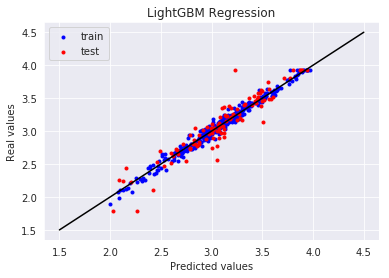

In [131]:
y_train_pred = light_gbm.predict(X_train)
y_test_pred = light_gbm.predict(X_test)
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = ".", label = "train")
plt.scatter(y_test_pred, y_test, c = "red", marker = ".", label = "test")
plt.title("LightGBM Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([1.5, 4.5], [1.5, 4.5], c = "black")
plt.show()

## Stacking models Approaches

### Simple Ensemble (Average)

In [132]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [133]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   



In [134]:
averaged_models = AveragingModels(models = (elasticNet, gboost, KRR, xgboost))

In [135]:
score = rmse_5cv(averaged_models)

In [136]:
score

array([0.12266477, 0.10999034, 0.13291314, 0.13276785, 0.1476263 ])

In [137]:
score.mean()

0.12919248061113095

In [138]:
averaged_models.fit(X_train, y_train)
y_test_pred = averaged_models.predict(X_test)
print(np.sqrt(mean_squared_error(y_test_pred,y_test)))

0.14996874388966863


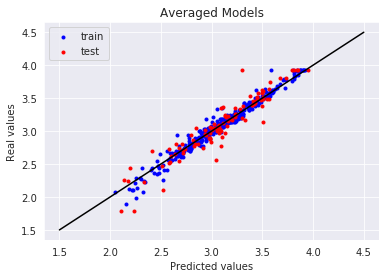

In [139]:
y_train_pred = averaged_models.predict(X_train)
y_test_pred = averaged_models.predict(X_test)
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = ".", label = "train")
plt.scatter(y_test_pred, y_test, c = "red", marker = ".", label = "test")
plt.title("Averaged Models")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([1.5, 4.5], [1.5, 4.5], c = "black")
plt.show()

## Stacking models with a Meta-model

In [284]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X_train, y_train):
        #make dummy list
        self.base_models_ = [list() for x in range(len(self.base_models))]
        #deep copy
        self.meta_model_ = clone(self.meta_model)
        #k-fold spilt
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=101)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        
        # (the number of house prices predicted), (the number of level 0 models)
        out_of_fold_predictions = np.zeros((X_train.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X_train, y_train):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X_train[train_index], y_train[train_index])
                y_pred = instance.predict(X_train[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y_train)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X_test):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X_test) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [285]:
elanet = ElasticNet(alpha=alpha, l1_ratio=ratio)
gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
KRR = KernelRidge(alpha=0.13999, kernel='polynomial', degree=7, coef0=3.5)

lasso = Lasso(alpha=6e-05)


In [291]:
stacked_averaged_models = StackingAveragedModels(base_models = (elanet, gboost, KRR),
                                                 meta_model = lasso)

In [292]:
score = rmse_5cv(stacked_averaged_models)

In [293]:
score

array([0.14091998, 0.13710289, 0.16724807, 0.13995997, 0.16457947])

In [294]:
score.mean()

0.14996207722961524

In [295]:
stacked_averaged_models.fit(X_train, y_train)
y_test_pred = stacked_averaged_models.predict(X_test)
print(np.sqrt(mean_squared_error(y_test_pred,y_test)))

0.16366641998307377
